<Figure size 640x480 with 0 Axes>

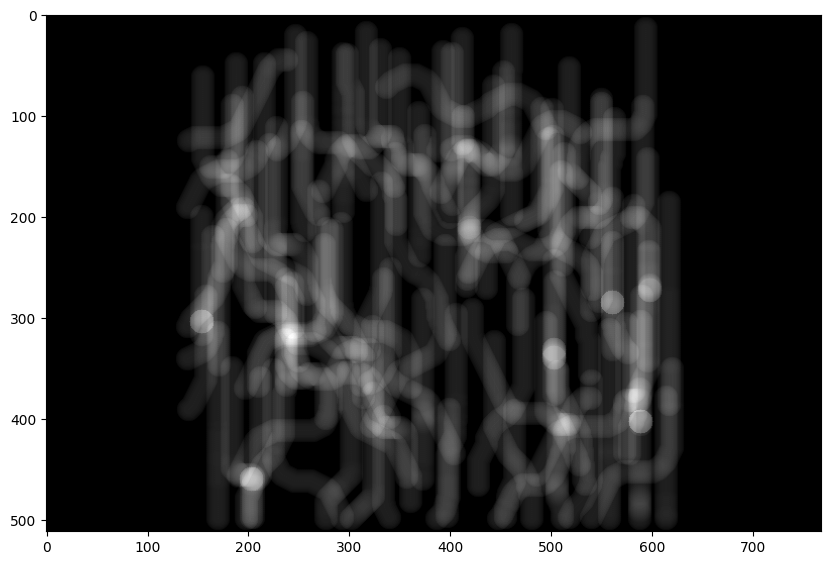

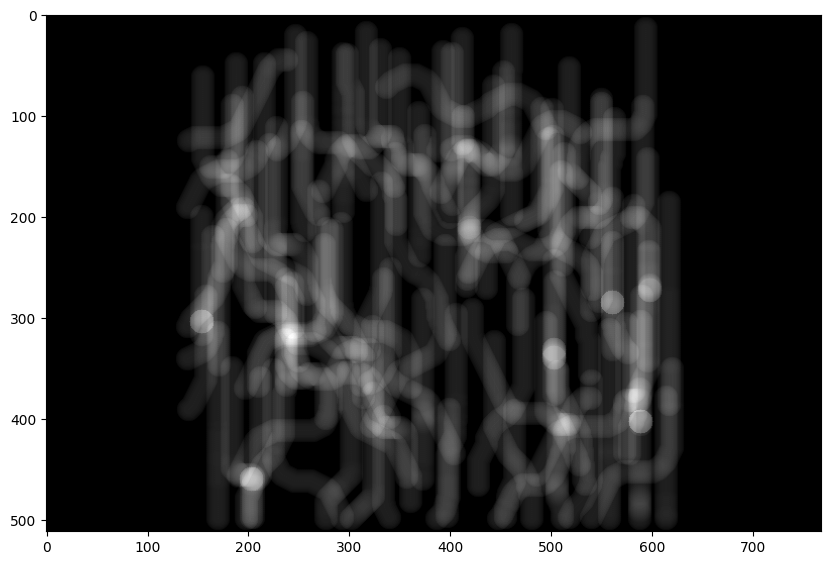

In [66]:
import astra
import numpy as np
import pylab
import matplotlib.pyplot as plt


volume = np.load('volume.npy')

if volume.shape != (512, 512, 512):
    raise ValueError("Volume dimensions are not 512x512x512.")

vol_geom = astra.create_vol_geom(512, 512, 512)

angles = np.linspace(0, np.pi, 180, False)
proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, 512, 768, angles)


proj_id_original, proj_data_original = astra.create_sino3d_gpu(volume, proj_geom, vol_geom)

####################################

# # Poisson
# scale_factor = 1e1
# proj_data_noisy = np.random.poisson(proj_data_original * scale_factor) / scale_factor

# https://dmpelt.github.io/foam_ct_phantom/_modules/foam_ct_phantom/artifacts.html#apply_poisson_noise

####################################

# # Gaussian
# mu = 0  # Mean 
# sigma = 0.05  # standard dev

# noise = np.random.normal(mu, sigma, proj_data_original.shape)
# proj_data_noisy = proj_data_original + noise

# proj_data_noisy = np.clip(proj_data_noisy, 0, 1)

####################################

# s&p noise
import numpy as np

def add_salt_pepper_noise_3D(image, salt_prob, pepper_prob):

    noisy_image = np.copy(image)
    
    total_pixels = image.size #voxel
    
    num_salt = np.ceil(salt_prob * total_pixels).astype(int)
    num_pepper = np.ceil(pepper_prob * total_pixels).astype(int)
    
    salt_indices = np.random.choice(total_pixels, num_salt, replace=False) # flat indices
    pepper_indices = np.random.choice(total_pixels, num_pepper, replace=False) # depth, height, width
    
    salt_coords = np.unravel_index(salt_indices, image.shape)
    pepper_coords = np.unravel_index(pepper_indices, image.shape)
    
    noisy_image[salt_coords] = np.max(image)  
    noisy_image[pepper_coords] = np.min(image) 

    return noisy_image


salt_prob = 0.5  
pepper_prob = 0.5  
proj_data_noisy = add_salt_pepper_noise_3D(proj_data_original, salt_prob, pepper_prob)

####################################

proj_id_noisy = astra.data3d.create('-sino', proj_geom, proj_data_noisy)

pylab.gray()
pylab.figure(figsize=(10, 8))
pylab.imshow(proj_data[:, int(proj_data.shape[1] / 2), :])

pylab.gray()
pylab.figure(figsize=(10, 8))
pylab.imshow(proj_data[:, int(proj_data_noisy.shape[1] / 2), :])

rec_id_original = astra.data3d.create('-vol', vol_geom)
cfg_original = astra.astra_dict('SIRT3D_CUDA')
cfg_original['ReconstructionDataId'] = rec_id_original
cfg_original['ProjectionDataId'] = proj_id_original
alg_id_original = astra.algorithm.create(cfg_original)
astra.algorithm.run(alg_id_original, 150)
rec_original = astra.data3d.get(rec_id_original)

rec_id_noisy = astra.data3d.create('-vol', vol_geom)
cfg_noisy = astra.astra_dict('SIRT3D_CUDA')
cfg_noisy['ReconstructionDataId'] = rec_id_noisy
cfg_noisy['ProjectionDataId'] = proj_id_noisy
alg_id_noisy = astra.algorithm.create(cfg_noisy)
astra.algorithm.run(alg_id_noisy, 150)
rec_noisy = astra.data3d.get(rec_id_noisy)

astra.algorithm.delete(alg_id_original)
astra.algorithm.delete(alg_id_noisy)
astra.data3d.delete(rec_id_original)
astra.data3d.delete(rec_id_noisy)
astra.data3d.delete(proj_id_original)
astra.data3d.delete(proj_id_noisy)



Text(0.5, 1.0, 'Difference bet Original and Noisy Projection')

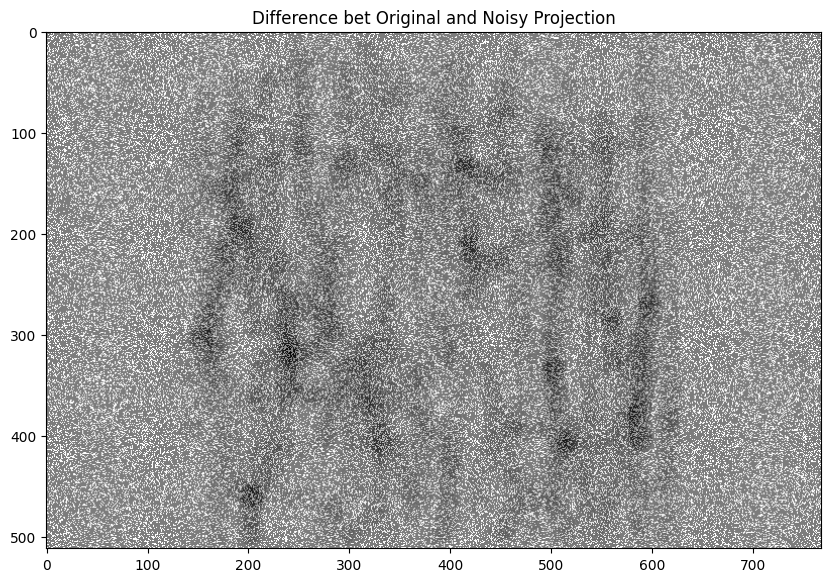

In [67]:
# Calculate the difference for the visualized slice
difference_slice = proj_data_noisy[:, int(proj_data_noisy.shape[1] / 2), :] - proj_data[:, int(proj_data.shape[1] / 2), :]

# Visualize the difference
pylab.figure(figsize=(10, 8))
pylab.gray()
pylab.imshow(difference_slice)
pylab.title('Difference bet Original and Noisy Projection')

In [68]:
def mse(imageA, imageB):
    if imageA.ndim != 3 or imageB.ndim != 3:
        raise ValueError("Both images must be 3D arrays.")
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2) # summation of square diff
    err /= float(imageA.size)
    return err

def rmse(imageA, imageB):
    return np.sqrt(mse(imageA, imageB))


rmse_original = rmse(volume, rec)
rmse_noisy = rmse(volume, rec_noisy)

print("RMSE Original Reconstruction:", rmse_original)
print("RMSE Noisy Reconstruction:", rmse_noisy)

RMSE Original Reconstruction: 0.05773954547750316
RMSE Noisy Reconstruction: 1.6724554506922709


In [13]:
# For Slicer3D compatibility, convert to .nii

import numpy as np
import nibabel as nib


original_vol = nib.Nifti1Image(volume, np.eye(4))
reconstructed_vol = nib.Nifti1Image(rec, np.eye(4))

# Save the NIFTI image to disk
nib.save(original_vol, 'original_vol.nii')
nib.save(reconstructed_vol, 'reconstructed_vol.nii')

